# Schilderijen classificeren

In [36]:
import os
import zipfile
import shutil
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16

In [2]:
# *** Stap 1: Directories instellen ***
base_dir = '/content/schilderijen_data'
os.makedirs(base_dir, exist_ok=True)

In [3]:
# *** Stap 2: Zip-bestanden en subfolders ***
zip_files = {
    "Mondriaan": "Mondriaan.zip",
    "Picasso": "Picasso.zip",
    "Rubens": "Rubens.zip",
    "Rembrandt": "rembrandt.zip"
}


In [9]:
# *** Stap 3: Zip-bestanden uitpakken ***
for painter, zip_path in zip_files.items():
    folder_path = os.path.join(base_dir, painter)
    os.makedirs(folder_path, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(folder_path)
    print(f"Uitgepakt: {zip_path} naar {folder_path}")

    # Verplaats bestanden van subfolder(s) naar hoofdmap (indien nodig)
    for root, dirs, files in os.walk(folder_path):
        for dir_name in dirs:
            subfolder_path = os.path.join(root, dir_name)
            for file_name in os.listdir(subfolder_path):
                source_path = os.path.join(subfolder_path, file_name)
                target_path = os.path.join(folder_path, file_name)
                if os.path.isfile(source_path):
                    shutil.move(source_path, target_path)
            # Verwijder lege subfolder
            os.rmdir(subfolder_path)
        break  # Alleen de eerste laag checken

Uitgepakt: Mondriaan.zip naar /content/schilderijen_data/Mondriaan
Uitgepakt: Picasso.zip naar /content/schilderijen_data/Picasso
Uitgepakt: Rubens.zip naar /content/schilderijen_data/Rubens
Uitgepakt: rembrandt.zip naar /content/schilderijen_data/Rembrandt


In [10]:
# *** Stap 4: Aantal afbeeldingen per folder controleren ***
def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

image_counts = {painter: count_images_in_folder(os.path.join(base_dir, painter)) for painter in zip_files.keys()}
print("\nAantal afbeeldingen per folder:")
for painter, count in image_counts.items():
    print(f"{painter}: {count} afbeeldingen")


Aantal afbeeldingen per folder:
Mondriaan: 330 afbeeldingen
Picasso: 1529 afbeeldingen
Rubens: 682 afbeeldingen
Rembrandt: 108 afbeeldingen


In [11]:
# *** Stap 5: Dataset statistieken verzamelen ***
def collect_image_statistics(folder_path):
    sizes = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(folder_path, filename)
            try:
                with Image.open(file_path) as img:
                    sizes.append(img.size)
            except Exception as e:
                print(f"Error bij verwerken: {file_path}")
    if sizes:
        widths, heights = zip(*sizes)
        stats = {
            "Aantal": len(sizes),
            "Min grootte": (min(widths), min(heights)),
            "Max grootte": (max(widths), max(heights)),
            "Gemiddelde grootte": (np.mean(widths), np.mean(heights)),
            "Mediaan grootte": (np.median(widths), np.median(heights)),
            "P25 grootte": (np.percentile(widths, 25), np.percentile(heights, 25)),
            "P75 grootte": (np.percentile(widths, 75), np.percentile(heights, 75)),
        }
        return stats
    return None

all_stats = {}
for painter in zip_files.keys():
    folder_path = os.path.join(base_dir, painter)
    stats = collect_image_statistics(folder_path)
    if stats:
        all_stats[painter] = stats

print("\nDataset statistieken:")
for painter, stats in all_stats.items():
    print(f"\n{painter}:")
    for key, value in stats.items():
        print(f"  {key}: {value}")


Dataset statistieken:

Mondriaan:
  Aantal: 330
  Min grootte: (186, 180)
  Max grootte: (5918, 6000)
  Gemiddelde grootte: (690.6363636363636, 666.8060606060606)
  Mediaan grootte: (719.5, 678.5)
  P25 grootte: (400.0, 398.5)
  P75 grootte: (807.75, 800.0)

Picasso:
  Aantal: 1529
  Min grootte: (136, 131)
  Max grootte: (4608, 4608)
  Gemiddelde grootte: (561.9208633093525, 637.6579463701765)
  Mediaan grootte: (400.0, 400.0)
  P25 grootte: (302.0, 400.0)
  P75 grootte: (783.0, 878.0)

Rubens:
  Aantal: 682
  Min grootte: (181, 180)
  Max grootte: (7264, 6017)
  Gemiddelde grootte: (694.0366568914956, 694.5821114369502)
  Mediaan grootte: (606.5, 668.5)
  P25 grootte: (352.25, 383.0)
  P75 grootte: (989.5, 861.0)

Rembrandt:
  Aantal: 108
  Min grootte: (60, 53)
  Max grootte: (700, 893)
  Gemiddelde grootte: (401.5833333333333, 457.94444444444446)
  Mediaan grootte: (465.0, 600.0)
  P25 grootte: (198.5, 230.0)
  P75 grootte: (587.0, 600.0)


**Corrupte bestanden verwijderen**

In [13]:
def check_and_remove_corrupt_images(directory):
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        try:
            with Image.open(file_path) as img:
                img.verify()  # Controleer of de afbeelding corrupt is
        except (IOError, SyntaxError) as e:
            print(f"Corrupt image: {file_path}")
            os.remove(file_path)

for painter in zip_files.keys():
    check_and_remove_corrupt_images(os.path.join(base_dir, painter))


**Afbeeldingen hernoemen:**

In [14]:
def rename_images(directory):
    for i, file_name in enumerate(os.listdir(directory)):
        if file_name.lower().endswith(('jpg', 'jpeg', 'png')):
            new_name = f"{i:04d}.jpg"
            os.rename(
                os.path.join(directory, file_name),
                os.path.join(directory, new_name)
            )

for painter in zip_files.keys():
    rename_images(os.path.join(base_dir, painter))


**Afbeeldingen converteren naar RGB:**

In [15]:
def convert_to_rgb(directory):
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if file_name.lower().endswith(('jpg', 'jpeg', 'png')):
            with Image.open(file_path) as img:
                rgb_img = img.convert("RGB")
                rgb_img.save(file_path)

for painter in zip_files.keys():
    convert_to_rgb(os.path.join(base_dir, painter))


**Afbeeldingen Resizen naar een Consistente Grootte:**

In [16]:
def resize_images(directory, target_size=(512, 512)):
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if file_name.lower().endswith(('jpg', 'jpeg', 'png')):
            with Image.open(file_path) as img:
                img.thumbnail(target_size, Image.Resampling.LANCZOS)
                img.save(file_path)

for painter in zip_files.keys():
    resize_images(os.path.join(base_dir, painter))


**Dataset splitsing**

In [18]:
def create_split_folders(base_dir, painters, split_ratios):
    # Maak de train, validation, en test folders aan
    for split in ['train', 'validation', 'test']:
        for painter in painters:
            split_folder = os.path.join(base_dir, split, painter)
            os.makedirs(split_folder, exist_ok=True)

def split_dataset(base_dir, painters, split_ratios):
    for painter in painters:
        painter_folder = os.path.join(base_dir, painter)
        images = [f for f in os.listdir(painter_folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        random.shuffle(images)

        # Bepaal hoeveel afbeeldingen naar elke split gaan
        train_count = int(split_ratios[0] * len(images))
        val_count = int(split_ratios[1] * len(images))

        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]

        # Verplaats de afbeeldingen naar de corresponderende mappen
        for split, split_images in zip(['train', 'validation', 'test'], [train_images, val_images, test_images]):
            for image in split_images:
                src = os.path.join(painter_folder, image)
                dst = os.path.join(base_dir, split, painter, image)
                shutil.move(src, dst)

# Verhoudingen voor train, validation, test splits
split_ratios = [0.7, 0.15, 0.15]

# Maak de mappenstructuur aan
create_split_folders(base_dir, zip_files.keys(), split_ratios)

# Split de dataset
split_dataset(base_dir, zip_files.keys(), split_ratios)


**Controle:**

In [19]:
def count_images_in_split(base_dir, split):
    for painter in zip_files.keys():
        split_folder = os.path.join(base_dir, split, painter)
        count = len([f for f in os.listdir(split_folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
        print(f"{split.capitalize()} - {painter}: {count} afbeeldingen")

for split in ['train', 'validation', 'test']:
    count_images_in_split(base_dir, split)


Train - Mondriaan: 230 afbeeldingen
Train - Picasso: 1070 afbeeldingen
Train - Rubens: 477 afbeeldingen
Train - Rembrandt: 75 afbeeldingen
Validation - Mondriaan: 49 afbeeldingen
Validation - Picasso: 229 afbeeldingen
Validation - Rubens: 102 afbeeldingen
Validation - Rembrandt: 16 afbeeldingen
Test - Mondriaan: 51 afbeeldingen
Test - Picasso: 230 afbeeldingen
Test - Rubens: 103 afbeeldingen
Test - Rembrandt: 17 afbeeldingen


**Visualisatie samples**


Train samples from Mondriaan:


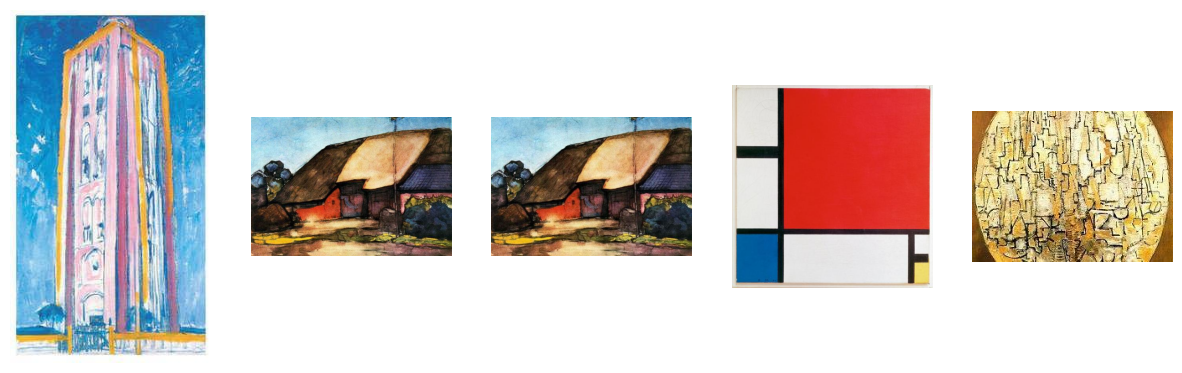


Train samples from Picasso:


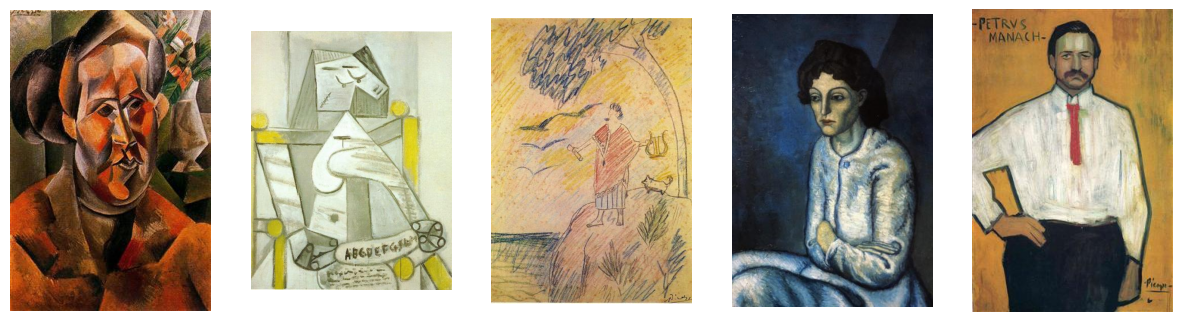


Train samples from Rubens:


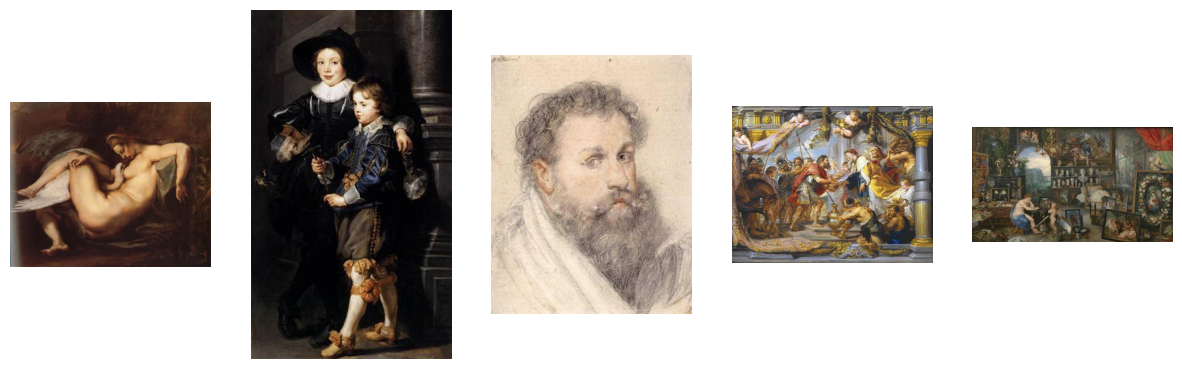


Train samples from Rembrandt:


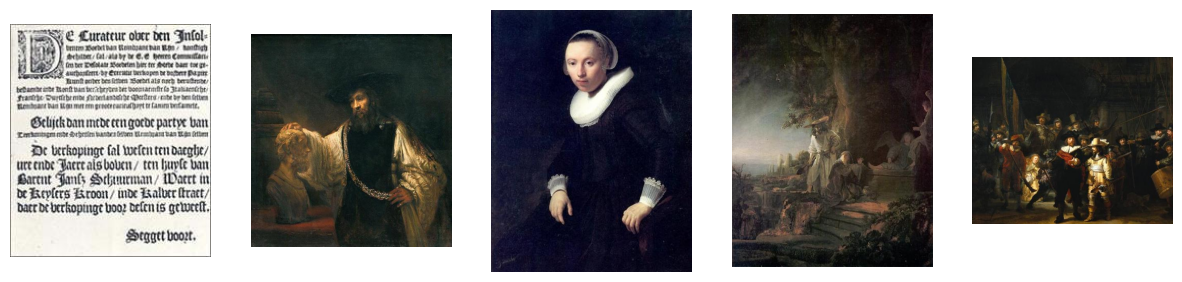

In [22]:
def visualize_samples(base_dir, painters, split, num_samples=5):
    for painter in painters:
        split_folder = os.path.join(base_dir, split, painter)
        images = os.listdir(split_folder)[:num_samples]
        print(f"\n{split.capitalize()} samples from {painter}:")

        # Plot afbeeldingen
        fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
        for i, image_name in enumerate(images):
            img_path = os.path.join(split_folder, image_name)
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
        plt.show()

visualize_samples(base_dir, zip_files.keys(), split='train', num_samples=5)


**Data augmentation**

Augmented Images:


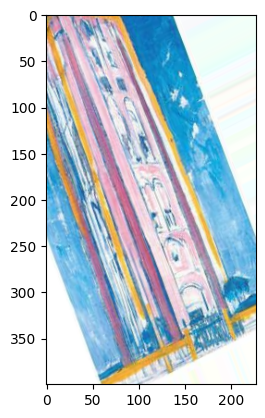

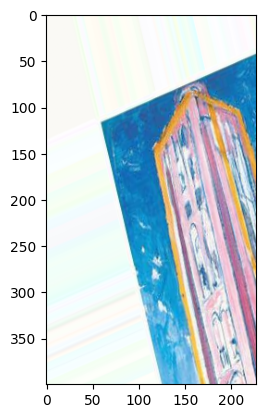

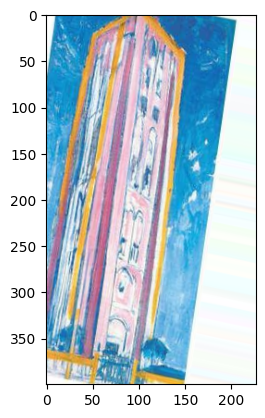

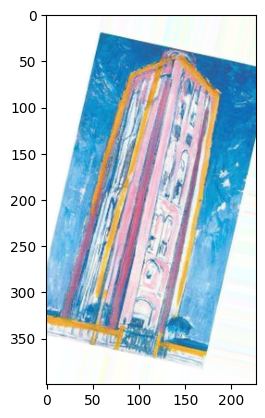

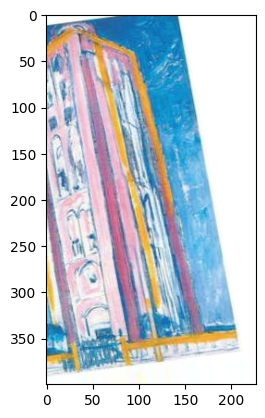

In [26]:
# Data augmentatie instellingen
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Voorbeeld van augmentatie
sample_image = os.path.join(base_dir, 'train', 'Mondriaan', os.listdir(os.path.join(base_dir, 'train', 'Mondriaan'))[0])
img = Image.open(sample_image)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)

print("Augmented Images:")
i = 0
for batch in datagen.flow(img_array, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(batch[0] / 255.0)
    i += 1
    if i == 5:  # Show 5 augmented samples
        break
plt.show()


**Simple Model**

In [39]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(zip_files.keys()), activation='softmax')  # Softmax voor multi-class classificatie
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# ImageDataGenerators voor elke split
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 1852 images belonging to 4 classes.
Found 396 images belonging to 4 classes.
Found 401 images belonging to 4 classes.


Train

In [41]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=[early_stopping]
)

model.save("simple_model.keras")

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 0.4997 - loss: 1.3952 - val_accuracy: 0.6849 - val_loss: 0.7208
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5938 - loss: 1.0104 - val_accuracy: 0.6667 - val_loss: 1.0215
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.7208 - loss: 0.7410 - val_accuracy: 0.7188 - val_loss: 0.6345
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.8871 - val_accuracy: 0.7500 - val_loss: 0.5306
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.7874 - loss: 0.5692 - val_accuracy: 0.8177 - val_loss: 0.5358
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.5077 - val_accuracy: 0.9167 - val_loss: 0.2688
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.8637 - loss: 0.3920 - val_accuracy: 0.7891 - val_loss: 0.5364
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8750 - loss: 0.4754 - val_accuracy: 0.6667 - v

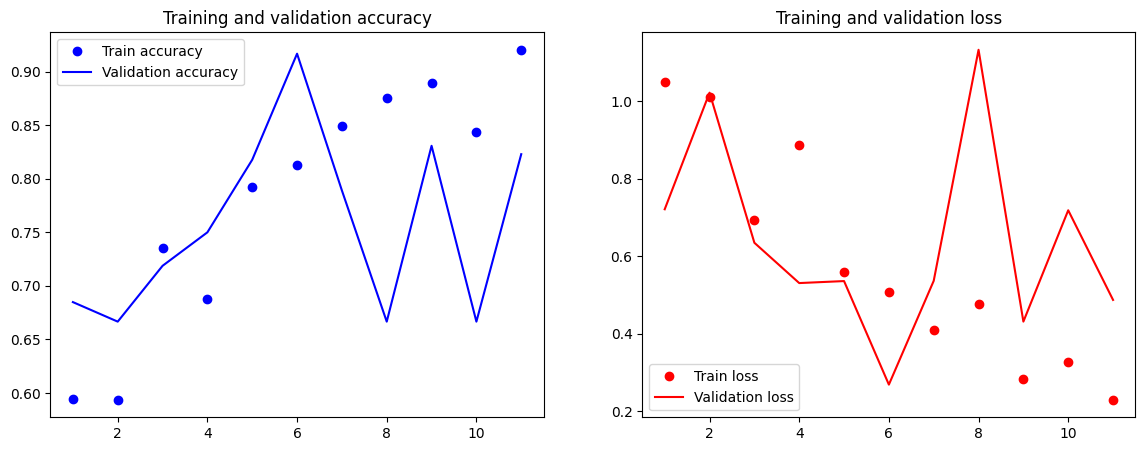

In [42]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot nauwkeurigheid
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Train accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    # Plot verlies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Train loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training(history)


**ConvNet**

In [35]:
# Eenvoudig ConvNet model
def build_simple_convnet(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Model opslaan en trainen
simple_convnet = build_simple_convnet((150, 150, 3), len(zip_files.keys()))
simple_checkpoint = ModelCheckpoint('simple_convnet.keras', save_best_only=True)

history_simple = simple_convnet.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True), simple_checkpoint]
)


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.5559 - loss: 1.1767 - val_accuracy: 0.6692 - val_loss: 0.7774
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6531 - loss: 0.8948 - val_accuracy: 0.7121 - val_loss: 0.6660
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7219 - loss: 0.6990 - val_accuracy: 0.7601 - val_loss: 0.5983
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.7826 - loss: 0.5977 - val_accuracy: 0.7929 - val_loss: 0.5116
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7994 - loss: 0.5117 - val_accuracy: 0.7778 - val_loss: 0.5482
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.8455 - loss: 0.4301 - val_accuracy: 0.8056 - val_loss: 0.4976
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.8775 - loss: 0.3155 - val_accuracy: 0.8182 - val_loss: 0.4682
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.8945 - loss: 0.3017 - val_accuracy: 0.85

**Feature Extractie met Pretrained Model**

In [37]:
def build_feature_extractor(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze de basis

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Model opslaan en trainen
feature_extractor = build_feature_extractor((150, 150, 3), len(zip_files.keys()))
feature_checkpoint = ModelCheckpoint('feature_extractor.keras', save_best_only=True)

history_feature = feature_extractor.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True), feature_checkpoint]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 399ms/step - accuracy: 0.6637 - loss: 0.8725 - val_accuracy: 0.8308 - val_loss: 0.3844
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.8415 - loss: 0.4196 - val_accuracy: 0.8561 - val_loss: 0.3283
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.8642 - loss: 0.3315 - val_accuracy: 0.8939 - val_loss: 0.2698
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.9013 - loss: 0.2476 - val_accuracy: 0.8914 - val_loss: 0.2520
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.9120 - loss: 0.2406 - val_accuracy: 0.8864 - val_loss: 0.2641
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9180 - loss: 0.2121 - val_accuracy: 0.8838 - val_loss: 0.2548
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.9232 - loss: 0.1785 - val_accuracy: 0.9167 - val_loss: 0.2182
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - 

**Fine-Tuning van Pretrained Model**

In [38]:
def build_fine_tuned_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True
    for layer in base_model.layers[:-4]:  # Laat alleen de laatste 4 lagen trainbaar
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),  # Lage learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Model opslaan en trainen
fine_tuned_model = build_fine_tuned_model((150, 150, 3), len(zip_files.keys()))
fine_tuned_checkpoint = ModelCheckpoint('fine_tuned_model.keras', save_best_only=True)

history_fine_tuned = fine_tuned_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True), fine_tuned_checkpoint]
)


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 18s 217ms/step - accuracy: 0.6983 - loss: 0.7573 - val_accuracy: 0.9015 - val_loss: 0.2959
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.8987 - loss: 0.2617 - val_accuracy: 0.9091 - val_loss: 0.2518
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.9472 - loss: 0.1670 - val_accuracy: 0.9242 - val_loss: 0.2821
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.9595 - loss: 0.1238 - val_accuracy: 0.9444 - val_loss: 0.1652
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9852 - loss: 0.0423 - val_accuracy: 0.9520 - val_loss: 0.1556
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9924 - loss: 0.0216 - val_accuracy: 0.9520 - val_loss: 0.1756
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.9988 - loss: 0.0065 - val_accuracy: 0.9596 - val_loss: 0.1687
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.9998 - loss: 0.0033 - val_accurac

dataset downloaden

In [49]:
import shutil

# Pad naar de map die je wilt zippen
folder_path = '/content/schilderijen_data'

# Pad voor de nieuwe zipfile
zip_path = '/content/schilderijen_data.zip'

# Zip de map
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)


'/content/schilderijen_data.zip'

In [50]:
from google.colab import files


files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
import os
os.path.getsize('/content/schilderijen_data.zip')



87464218